In [31]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl
import matplotlib.ticker as ticker


In [32]:
USER='wilderlavington' 
PROJECT='FuncOptCleanRuns'
SUMMARY_FILE='FuncOptCleanRuns_svmlib.csv'  
try:
    os.makedirs("plots/aistats/")
except FileExistsError:
    print("File already exists")

File already exists


In [33]:
%run plotting_utils.py

In [34]:
# download_wandb_summary(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [35]:
# download_wandb_records(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [36]:
def generate_sgd_figure(loss, schedule, wandb_records, fig_name, x ='optim_steps', y='avg_loss'):
    
    # base info   
    dataset_names = ['mushrooms', 'ijcnn', 'rcv1']
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20] 
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77', 'Adam': '#88CCEE'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-20': '#332288'})
    algorithms = ['SGD', 'Adam', 'SLS'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SLS', 
                                         linestyle='dashed', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

        # SGD
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SGD', 
                                         linestyle='dashed', color=colormap['SGD'])
        else:
            print('missing SGD  ', dataset_name, 'full-batch')
        
        # Adam
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
            'eta_schedule': 'constant', 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adam', 
                                         linestyle='dashed', color=colormap['Adam'])
        else:
            print('missing Adam  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch') 
        axs[row][-1].grid()     
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log") 
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0 
            
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                             linestyle='dashed', color=colormap['SLS'])
            else:
                print('missing SLS  ', dataset_name, batch_size)
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SGD', 
                                             linestyle='dashed', color=colormap['SGD'])
            else:
                print('missing SGD  ', dataset_name, batch_size)
            
            # Adam
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,  
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
                'eta_schedule': 'constant', 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adam', 
                                             linestyle='dashed', color=colormap['Adam'])
            else:
                print('missing Adam  ', dataset_name, batch_size)
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, #'_step': 499.0,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size) 
            
            axs[row][col].grid()     
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            axs[0][col].set_title('batch-size: '+str(batch_size), fontsize=22)
            axs[0][-1].set_title('full-batch', fontsize=22)
            axs[row][-1].set_ylabel(dataset_name, fontsize=22)
            axs[row][-1].yaxis.set_label_position("right") 
        
        axs[row][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
        axs[row][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
        axs[row][col].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
    # remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.65,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=18,
           ncol=7, 
           bbox_to_anchor=(0.525, -0.12),
           )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-plot-sgd_sso-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

In [37]:
 wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,49,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


missing FMDopt   5 mushrooms full-batch
missing FMDopt   20 mushrooms full-batch
missing FMDopt   5 rcv1 full-batch
missing FMDopt   10 rcv1 full-batch


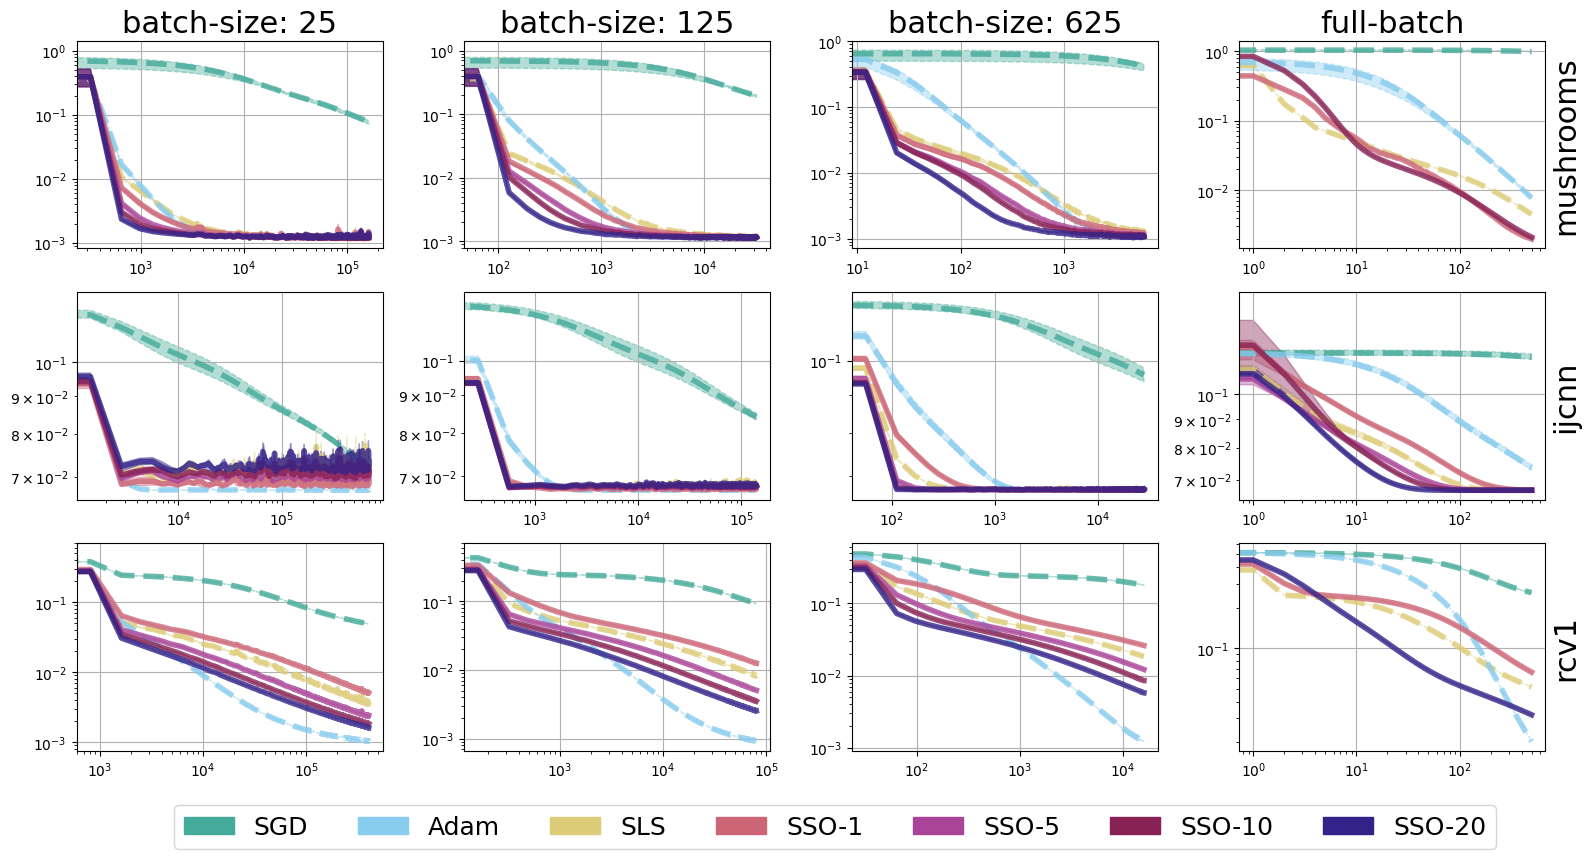

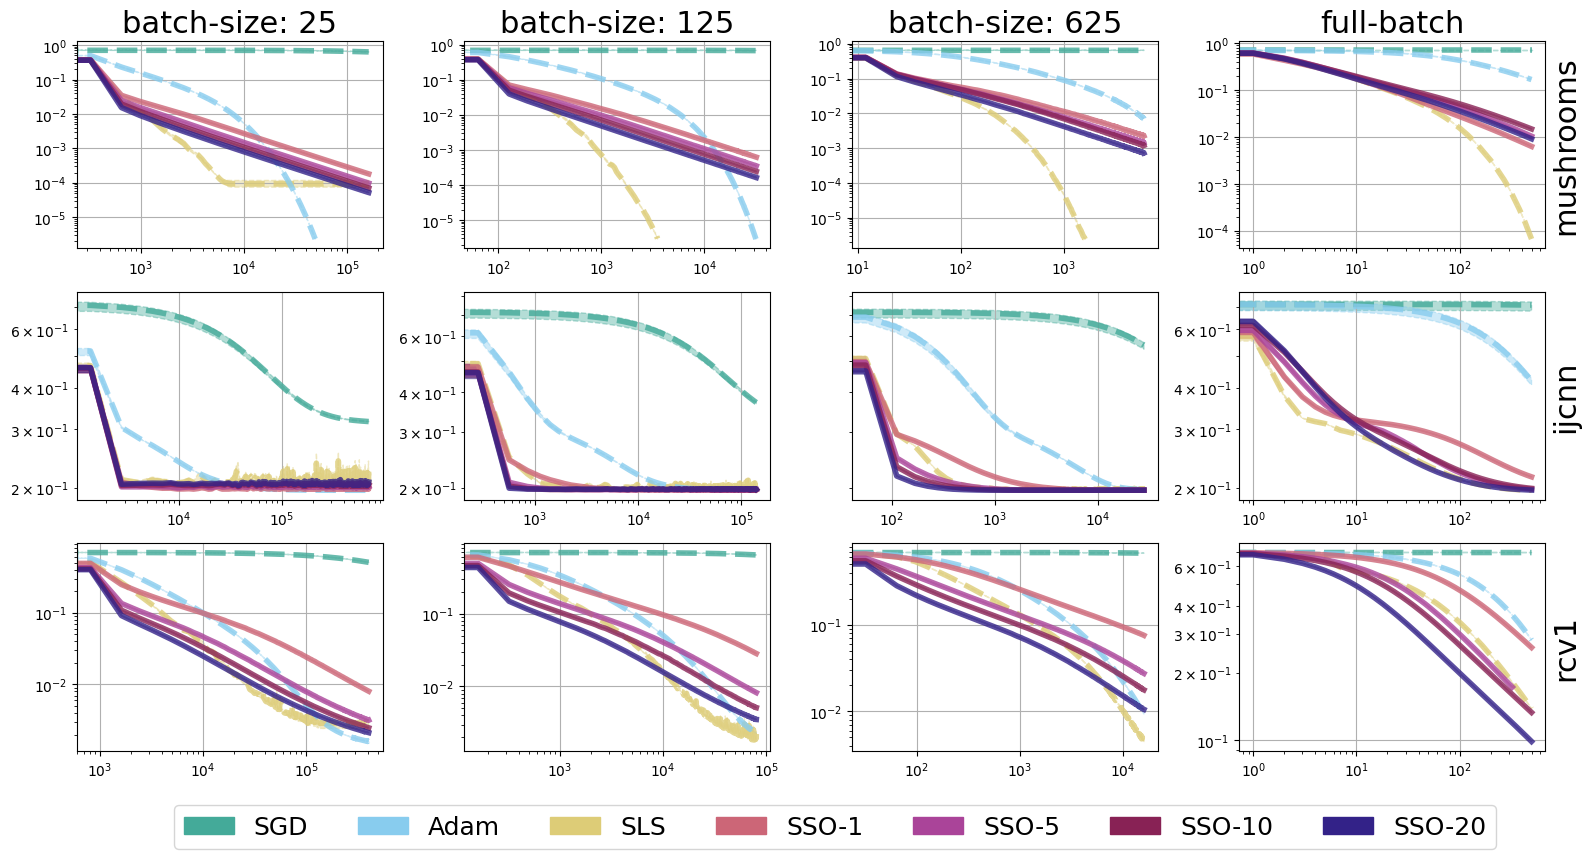

In [44]:
# loss comparison
generate_sgd_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='avg_loss')
generate_sgd_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_sgd_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# generate_sgd_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sgd_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

missing FMDopt   1 mushrooms full-batch
missing FMDopt   20 mushrooms full-batch
missing FMDopt   1 ijcnn full-batch
missing FMDopt   5 ijcnn full-batch


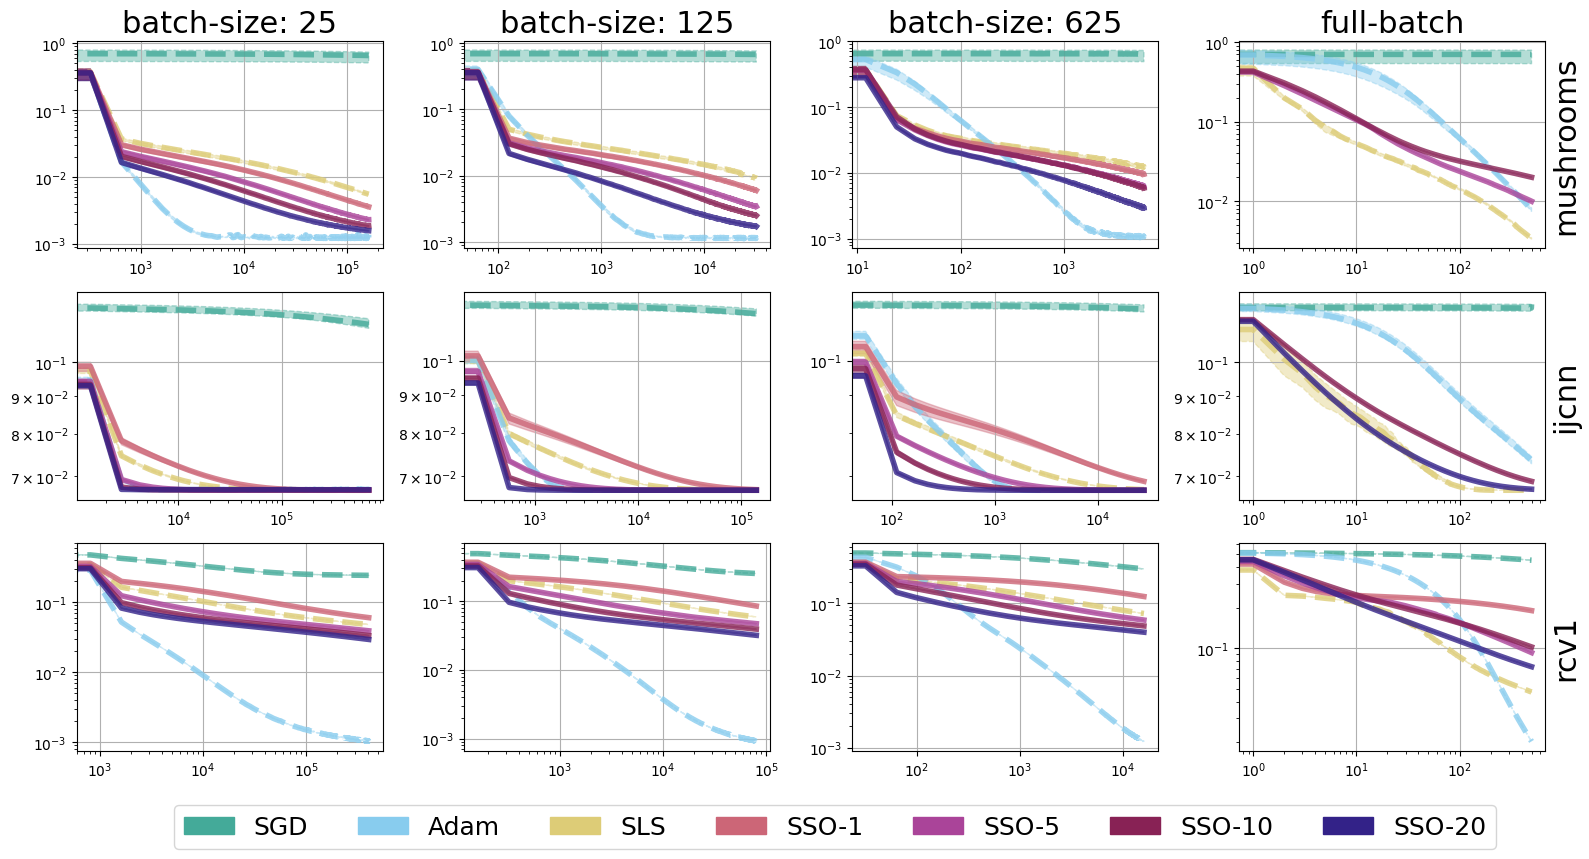

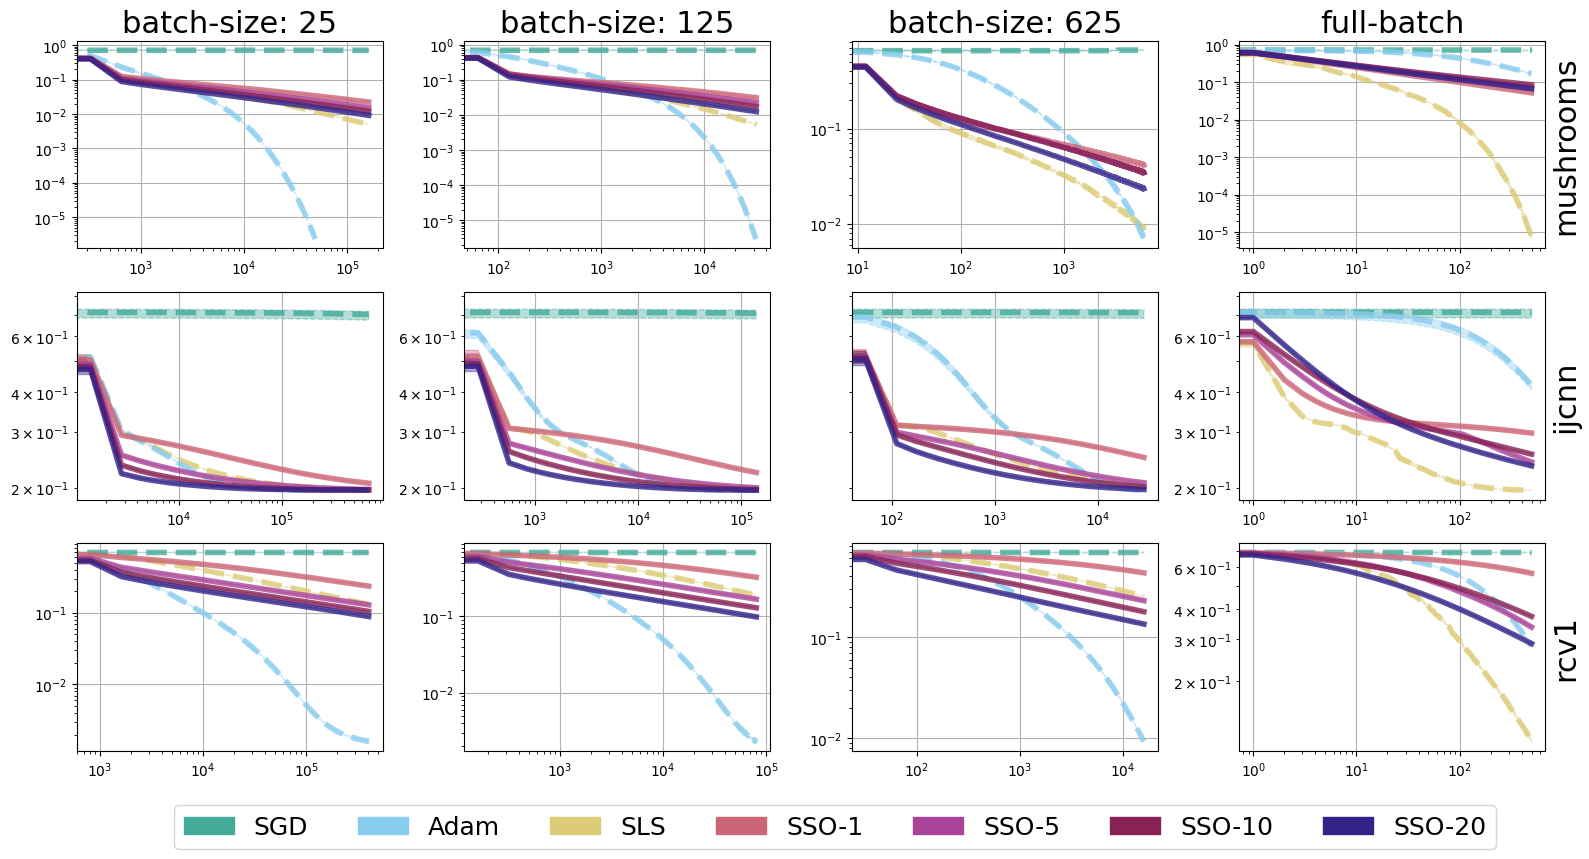

In [39]:
# loss comparison
generate_sgd_figure('MSELoss', 'stochastic', wandb_records, fig_name='b', x ='optim_steps', y='avg_loss')
generate_sgd_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, fig_name='b', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_sgd_figure('MSELoss', 'stochastic', wandb_records, fig_name='b', x ='optim_steps', y='grad_norm')
# generate_sgd_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, fig_name='b', x ='optim_steps', y='grad_norm')
# time-elapsed comparison
# generate_sgd_figure('MSELoss', 'stochastic', wandb_records, fig_name='b', x ='time_elapsed', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, fig_name='b', x ='time_elapsed', y='avg_loss')

missing SLS   mushrooms full-batch
missing SGD   mushrooms full-batch


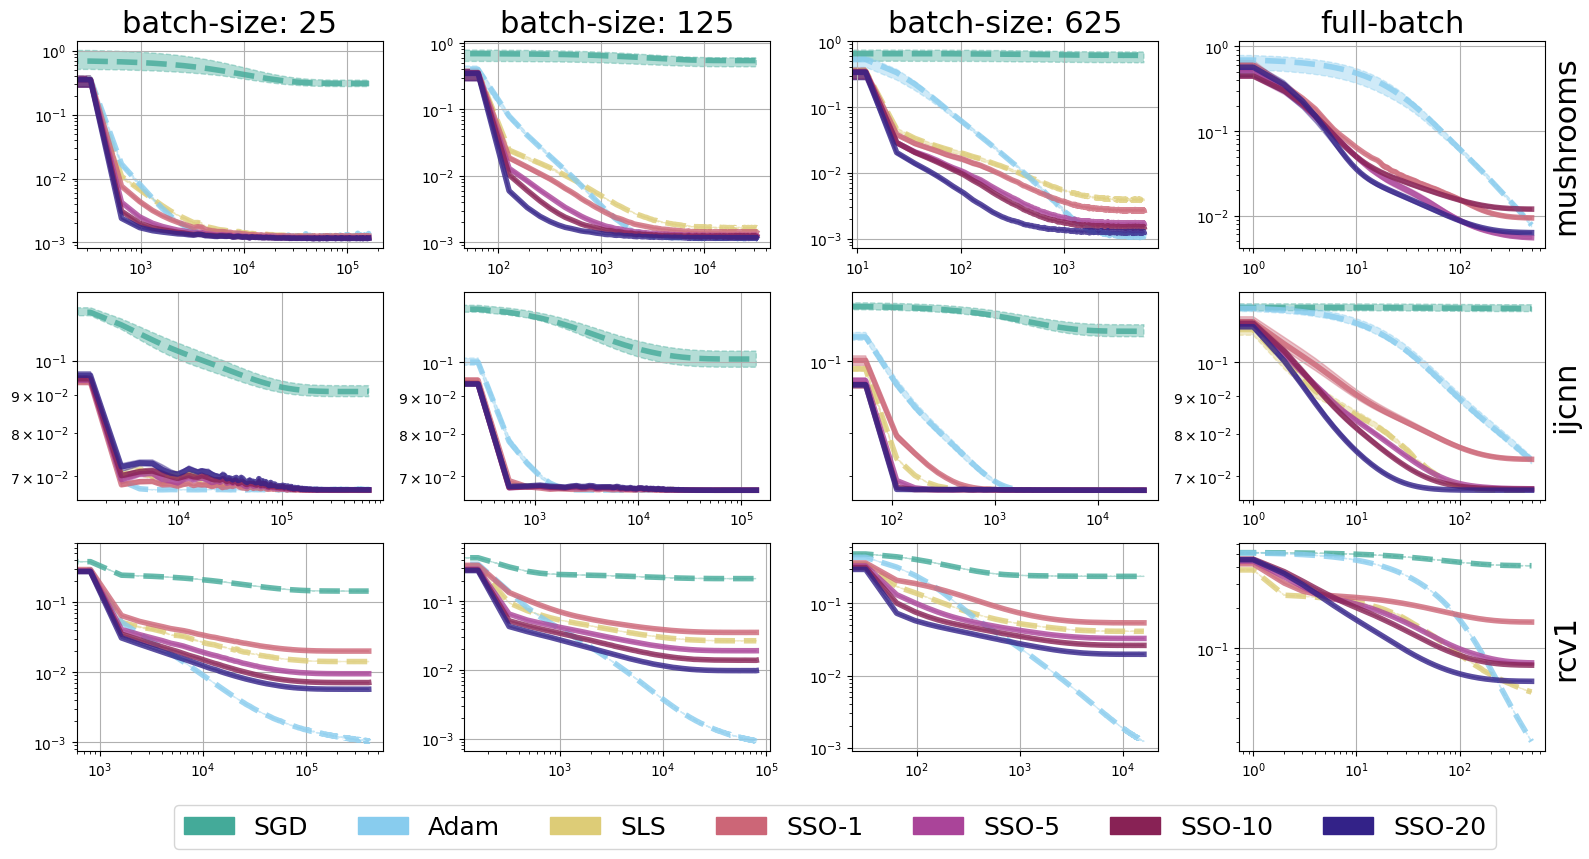

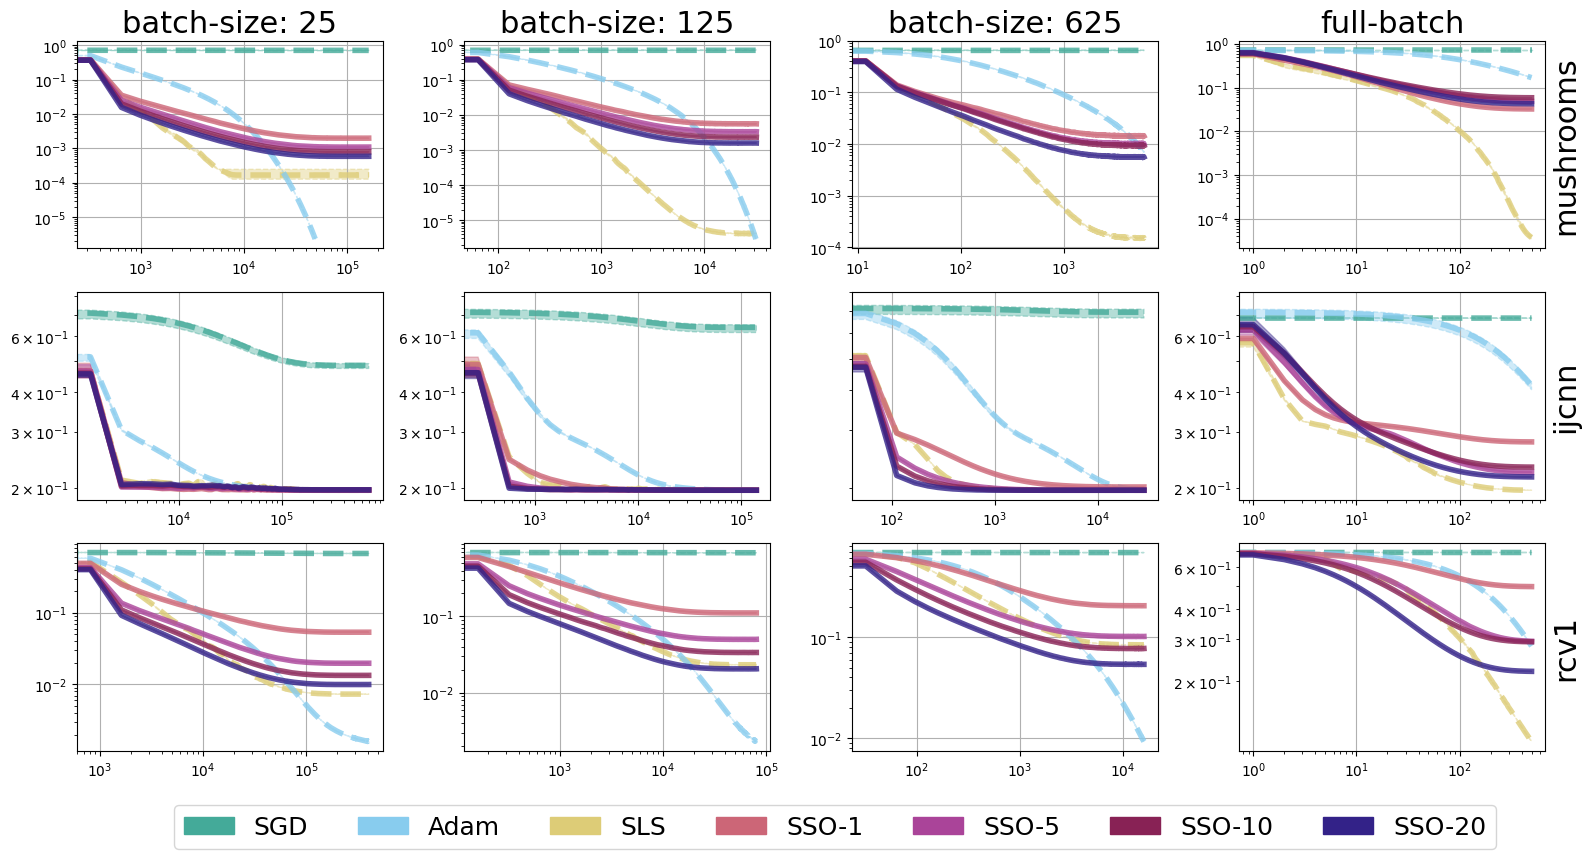

In [40]:
# loss comparison
generate_sgd_figure('MSELoss', 'exponential', wandb_records, fig_name='c', x ='optim_steps', y='avg_loss')
generate_sgd_figure('BCEWithLogitsLoss', 'exponential', wandb_records, fig_name='c', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_sgd_figure('MSELoss', 'exponential', wandb_records, fig_name='c', x ='optim_steps', y='grad_norm')
# generate_sgd_figure('BCEWithLogitsLoss', 'exponential', wandb_records, fig_name='c', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sgd_figure('MSELoss', 'exponential', wandb_records, fig_name='c', x ='time_elapsed', y='avg_loss')
# generate_sgd_figure('BCEWithLogitsLoss', 'exponential', wandb_records, fig_name='c', x ='time_elapsed', y='avg_loss')

In [41]:
def compute_qnt(wandb_records, id_subfields, x_max=50000000):
    run_times = [] 
    x = 'time_elapsed'
    y = 'avg_loss'
    for seed in [1,2,3]:
        try:
            id_subfields['seed'] = seed
            proc = format_dataframe(wandb_records, avg_subfields=['seed'],
                id_subfields=id_subfields, x_col=x , y_col=y) 
            low_order_idx = (torch.tensor(proc[x].values) < x_max).nonzero().reshape(-1)
            run_times.append(torch.tensor(proc[x].values[-1]).item())
#             print(proc[x].values)
        except:
            pass
    return np.mean(run_times), np.min(run_times), np.max(run_times)

In [42]:
 def generate_runtime_figure(loss, schedule, wandb_records, fig_name):
    
    # base info   
    x ='time_elapsed'
    y ='avg_loss'
    dataset_names = ['mushrooms', 'ijcnn', 'rcv1']
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20] 
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    algorithms = ['SGD', 'SLS'] + ['SSO-'+str(m_) for m_ in m] 
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-20': '#332288'})
    algorithms = ['SLS', 'SGD'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):

        # SLS
        id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name}
        meanrt, minrt, maxrt =  compute_qnt(wandb_records, id_subfields)
        algo_runtime = [meanrt]
        algo_min_runtime = [minrt]
        algo_max_runtime = [maxrt]
        
        # SGD 
        id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name}
        meanrt, minrt, maxrt =  compute_qnt(wandb_records, id_subfields)
        algo_runtime.append(meanrt) 
        algo_min_runtime.append(minrt)  
        algo_max_runtime.append(maxrt)  
    
        # FMDopt theoretical 
        fmd_proc_df = []
        for m_ in m:
            # create parsed info 
            id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}
            meanrt, minrt, maxrt =  compute_qnt(wandb_records, id_subfields)
            algo_runtime.append(meanrt) 
            algo_min_runtime.append(minrt)  
            algo_max_runtime.append(maxrt)  
        
        #
        axs[row][-1].barh(algorithms, algo_runtime, 
                          color=[colormap[algo] for algo in algorithms], 
#                           xerr=[algo_min_runtime, algo_max_runtime]
                         )
        axs[row][-1].grid()      
        
        for col, batch_size in enumerate(batch_sizes):
            
            # SLS
            id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name}
            meanrt, minrt, maxrt =  compute_qnt(wandb_records, id_subfields)
            algo_runtime = [meanrt]
            algo_min_runtime = [minrt]
            algo_max_runtime = [maxrt]
            
            # SGD
            id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name}
            meanrt, minrt, maxrt =  compute_qnt(wandb_records, id_subfields)
            algo_runtime.append(meanrt) 
            algo_min_runtime.append(minrt)  
            algo_max_runtime.append(maxrt)  
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name}
                meanrt, minrt, maxrt =  compute_qnt(wandb_records, id_subfields)
                algo_runtime.append(meanrt) 
                algo_min_runtime.append(minrt)  
                algo_max_runtime.append(maxrt)  
#             axs[row][col].grid()     
#             axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#             axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].barh(algorithms, algo_runtime, 
                          color=[colormap[algo] for algo in algorithms], 
#                           xerr=[algo_min_runtime, algo_max_runtime]
                              )
            axs[row][col].grid()  
#             axs[row][-1].grid(
#             axs[row][col].set_xscale("log")
 
    # remaining format stuff  
# #     handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
#     leg = fig.legend(handles=handles,
#            loc="lower center",   # Position of legend
#            borderaxespad=1.65,    # Small spacing around legend box
#            # title="Algorithms",  # Title for the legend
#            fontsize=18,
#            ncol=7, 
#            bbox_to_anchor=(0.525, -0.12),
#            )
    
#     plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()

    # show / save
    plt.savefig('plots/aistats/workshop-plot-sgd_sso-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

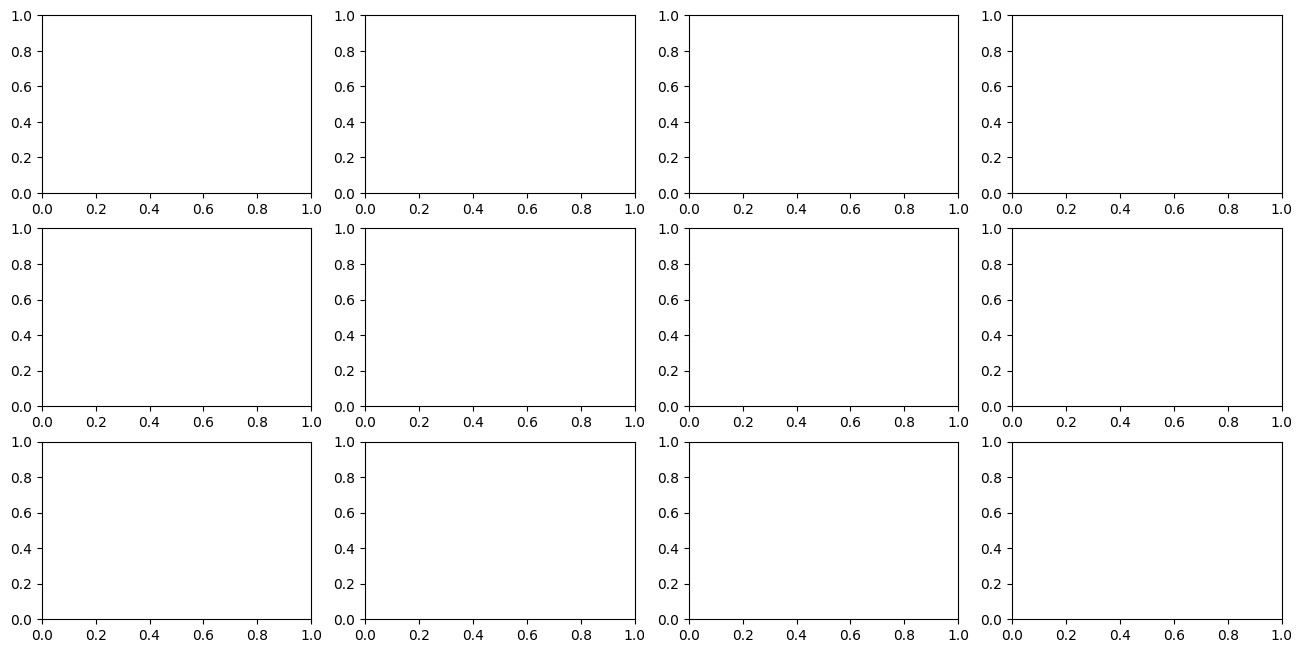

In [43]:
 generate_runtime_figure('MSELoss', 'constant', wandb_records, fig_name='fdf')